In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import sys
import cv2
from sklearn.feature_extraction import image
from skimage.util.shape import view_as_blocks
import time
from datetime import timedelta
import math
import os
from collections import Counter
import matplotlib.pyplot as plt

## Funtion Definitions

In [2]:
def distance(patch,cluster,C):
    min = sys.float_info.max
    for i in range(C):
        temp = np.square(patch - cluster[i]).mean()
        if(temp < min):
            min = temp
            idx = i
    return idx

def distortion(patches,cluster,index,prow,row,col):
    mse = np.zeros(prow)
    for i in range(prow):
        mse[i] = np.sum(np.square(patches[i] - cluster[index[i]]))
    return np.sum(mse)/(row*col)

def centroid(patches,index,prow,pcol,C):
    num_per_cluster = np.zeros(C)
    code_vector = np.zeros((C,p*p))
    for i in range(prow):
        num_per_cluster[index[i]] += 1
        for j in range(pcol):
            code_vector[index[i]][j] += patches[i][j]
    for i in range(C):
            code_vector[i] /= num_per_cluster[i]
    return np.rint(code_vector)

def training(patches,cluster,index,C,prow,row,col,k,r):
    temp = sys.maxsize
    for iteration in range(100):
        for i in range(prow):
            index[i] = distance(patches[i],cluster,C)
        dist[k] = distortion(patches,cluster,index,prow,row,col)
        print("Distortion " + str(iteration) + " (r = " + str(r[k]) + ") : " + str(dist[k]))
        cluster = centroid(patches,index,prow,pcol,C)
        if((temp - dist[k]) < 0.5):
            break
        temp = dist[k]
    return dist

def partition(img,block_shape,N,p):
    N = int(N)
    p = int(p)
    view = view_as_blocks(np.ascontiguousarray(img), block_shape)
    patches = np.reshape(view,(p*N,p))
    patches = np.reshape(view,(N,p*p))
    return patches

def stich(patches,cluster,index,row,col,N,p,prow):
    N = int(N)
    p = int(p)
    for i in range(prow):
        patches[i] = cluster[index[i]]
    z = int(row*col/p)
    patches = np.reshape(patches,(z,p))
    patches = np.reshape(patches,(int(row/p),int(col/p),p,p))
    patches = np.swapaxes(patches,1,2)
    patches = np.reshape(patches,(p,p,N))
    patches = np.reshape(patches,(row,col))
    return patches

def show_img(img,compressed_image,r,figure,p):
#     cv2.imshow('compressed image{}_ R = {}'.format(figure,r),compressed_image)
    cv2.imwrite('results/p={}/compressed_image{}_R{}.jpg'.format(p,figure,r), compressed_image)

def clip_image(img):
    row,col = img.shape
    row = 2**int(math.log(row,2))
    col = 2**int(math.log(col,2))
    return img[0:int(row),0:int(col)],int(row),int(col)

def test(cluster,C,p,block_shape,r):
    img1 = cv2.imread('data/lena-gray.bmp',0)
    img,row,col = clip_image(img1)
#     cv2.imshow('Original Image Testing',img)
    N = int(row*col/(p*p))
    print(N,p,row,col)
    patches = partition(img,block_shape,N,p)
    prow,pcol = patches.shape
    index = np.zeros(prow).astype(int)
    for i in range(prow):
        index[i] = distance(patches[i],cluster,C)
    print('Test Image Distortion for R={}:  '.format(r), distortion(patches,cluster,index,prow,row,col))
    reconstructed_image = stich(patches,cluster,index,row,col,N,p,prow) 
    show_img(img,reconstructed_image,r,1,p)

## Main Code Begins Here

P :  2


No. of Clusters:  2
Distortion 0 (r = 0.2) : 10715.792043685913
Distortion 1 (r = 0.2) : 2677.367681503296
Distortion 2 (r = 0.2) : 1731.9825649261475
Distortion 3 (r = 0.2) : 1692.5733814239502
Distortion 4 (r = 0.2) : 1681.2037906646729
Distortion 5 (r = 0.2) : 1677.4872856140137
Distortion 6 (r = 0.2) : 1676.2764568328857
Distortion 7 (r = 0.2) : 1676.0508480072021
H : 0.9597620002835408
Rate = 0.2399405000708852
There is a 0.19970250035442588% increase in coding rate
65536 2 512 512
Test Image Distortion for R=0.2:   8832.35954284668
Duration: 35.91624188423157 s 


No. of Clusters:  3
Distortion 0 (r = 0.4) : 7509.001226425171
Distortion 1 (r = 0.4) : 1285.1558856964111
Distortion 2 (r = 0.4) : 997.5174198150635
Distortion 3 (r = 0.4) : 981.0181541442871
Distortion 4 (r = 0.4) : 979.2244567871094
Distortion 5 (r = 0.4) : 978.9004516601562
H : 1.539618420506912
Rate = 0.384904605126728
There is a 0.037738487183179986% reduction in coding rate
65536 2 512 512
Test Image Dis

Distortion 17 (r = 0.25) : 657.1209030151367
Distortion 18 (r = 0.25) : 656.6873111724854
H : 3.6601360585416254
Rate = 0.2287585036588516
There is a 0.08496598536459365% reduction in coding rate
16384 4 512 512
Test Image Distortion for R=0.25:   4867.45006942749
Duration: 112.49762082099915 s 
Done


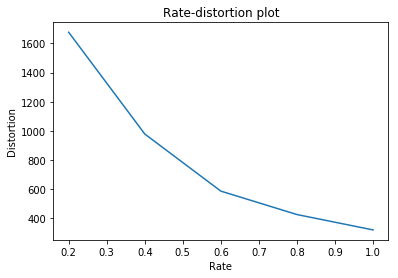

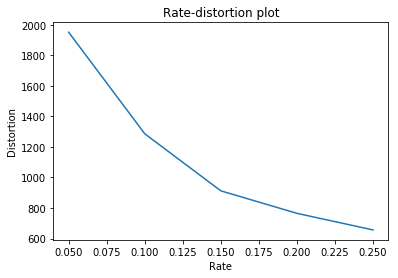

In [3]:
img1 = cv2.imread('data/image.png',0)
img,row,col = clip_image(img1)
# cv2.imshow('Original Image Training',img)
ps = [2, 4]
for p in ps:
    print('P : ', p)
    if (p == 2):
        r = [0.2, 0.4, 0.6, 0.8, 1.0]
    else:
        r = [0.05, 0.1, 0.15, 0.2, 0.25]
    start_time = np.zeros(len(r))
    dist = np.zeros(len(r))
    elapsed_time = np.zeros(len(r))
    R = np.zeros(len(r))

    for k in range(len(r)):
        C = int(round(2**(r[k]*(p**2))))
        N = row*col/(p*p)
        start_time[k] = time.time()
        print("\n")
        print('No. of Clusters: ',C)

        block_shape = (p,p)
        patches = partition(img,block_shape,N,p)
        prow,pcol = patches.shape

        cluster = np.zeros((C,p*p))
        index = np.zeros(prow).astype(int)
        for j in range(C):
            cluster[j] = [patches[np.random.randint(prow)][i] for i in range(pcol)]

        dist = training(patches,cluster,index,C,prow,row,col,k,r)
        if k == len(r)-1:
            fig = plt.figure()
            plt.plot(r, dist)
            plt.title('Rate-distortion plot')
            plt.xlabel('Rate')
            plt.ylabel('Distortion')
    #         plt.show()
            fig.savefig('results/p={}/rate-distortion-plot'.format(p))
        compressed_image = stich(patches,cluster,index,row,col,N,p,prow) 

        # print("Cluster : ")
        # print(cluster)
        # print("Patches : ")
        # print(patches)
        # print("Index : ")
        # print(index)

        unique, counts = np.unique(index, return_counts=True) 
        dict(zip(unique, counts))
        # print(Counter(index))
        # print(unique, counts)
        Ni = np.zeros(len(counts))
        for q in range(len(counts)):
            Ni[q] = counts[q]
        pi = np.zeros(len(cluster))
        H = np.zeros(len(cluster))
        # print("N : " + str(N))
        pi = Ni/N
        # print("Probability : ")
        # print(pi)
        H = -np.sum(np.multiply(pi, np.log2(pi)))
        print("H : " + str(H))
        R[k] = H/(p**2)
        print("Rate = " + str(R[k]))
        rate_change = (r[k]-R[k])/r[k]
        if rate_change > 0:
            print("There is a " + str(rate_change) + "% reduction in coding rate")
        if rate_change < 0:
            print("There is a " + str(-rate_change) + "% increase in coding rate")

        show_img(img,compressed_image,r[k],0,p)

        test(cluster,C,p,block_shape,r[k])

        elapsed_time[k] = time.time() - start_time[k]
        print("Duration: {} s ".format(elapsed_time[k]))
print('Done')
cv2.waitKey(0)
cv2.destroyAllWindows()